<a href="https://colab.research.google.com/github/viswambhar-yasa/image_captioning/blob/master/training_value_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/viswambhar-yasa/image_captioning

Cloning into 'image_captioning'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 43 (delta 18), reused 19 (delta 6), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [6]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile


def downloading_extraction(link, extraction_path='.'):
    url = urlopen(link)
    zipfile = ZipFile(BytesIO(url.read()))
    zipfile.extractall(path=extraction_path)


if __name__ == "__main__":
    images_link = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
    downloading_extraction(images_link)
    text_link = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
    downloading_extraction(text_link)


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Embedding, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers.recurrent import GRU

In [8]:
def image_encoder(img_input, trainable_layers=0, CNN_Type='Xception', Embed_Size=512, display=False):
    print('Building CNN model')
    if CNN_Type == 'Xception':
        cnn_pre_trained_model = Xception(include_top=False, weights='imagenet', input_tensor=img_input)
    elif CNN_Type =='ResNet':
      cnn_pre_trained_model =ResNet50(include_top=False,weights='imagenet',input_tensor=img_input,pooling='avg')
    else:
        cnn_pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=img_input)
    for i, layer in enumerate(cnn_pre_trained_model.layers):
        if len(cnn_pre_trained_model.layers) - i < trainable_layers:
            layer.trainable = True
        else:
            layer.trainable = False
    cnn_inputs = cnn_pre_trained_model.inputs
    base_model = cnn_pre_trained_model.output
    if CNN_Type=='ResNet':
      embed_image = tf.keras.layers.Dense(Embed_Size, activation='relu', name='embed_image')(base_model)
    else:
      embed_image = GlobalAveragePooling2D(name='global_average_pooling')(base_model)
    feature_extraction_model = Model(inputs=cnn_inputs, outputs=embed_image, name='CNN encoder model')
    print('CNN model {output shape}:', embed_image.shape)
    if display:
        tf.keras.utils.plot_model(feature_extraction_model, to_file='base_model.png', show_shapes=True)
    return feature_extraction_model


def txt_decoder(rnn_input, Embed_Size=256, Bi_Direction=False, RNN_Type='LSTM', RNN_Layers=2):
    print('Building RNN model')
    for i in range(RNN_Layers):
        x = BatchNormalization()(rnn_input)
        if RNN_Type == 'LSTM':
            if i == (RNN_Layers - 1):
                if Bi_Direction:
                    rnn_out = Bidirectional(LSTM(int(Embed_Size/2)))(x)
                else:
                    rnn_out = LSTM(Embed_Size)(x)
            else:
                if Bi_Direction:
                    rnn_out = Bidirectional(LSTM(int(Embed_Size/2), return_sequences=True))(x)
                else:
                    rnn_out = LSTM(Embed_Size, return_sequences=True)(x)
        else:
            if i == (RNN_Layers - 1):
                if Bi_Direction:
                    rnn_out = Bidirectional(GRU(Embed_Size))(x)
                else:
                    rnn_out = GRU(Embed_Size)(x)
            else:
                if Bi_Direction:
                    rnn_out = Bidirectional(GRU(Embed_Size/2, return_sequences=True))(x)
                else:
                    rnn_out = GRU(Embed_Size, return_sequences=True)(x)
        rnn_input = rnn_out
    return rnn_out


def Caption_model_gen(NET,Embedding_layer=None, img_shape=(256, 256, 3), vocab_size=5000, Embed_Size=256, max_length=20, display=False):
    img_input = tf.keras.Input(shape=img_shape)
    cnn_model = image_encoder(img_input, trainable_layers=0, CNN_Type='Xception', display=False)
    embed_image = tf.keras.layers.Dense(Embed_Size, activation='tanh')(cnn_model.output)

    text_input = tf.keras.Input(shape=(max_length,))
    if Embedding_layer==None:
      Embedding_layer = Embedding(input_dim=vocab_size, output_dim=Embed_Size, input_length=max_length, mask_zero=True)(
        text_input)
    else:
      Embedding_layer=Embedding_layer(text_input)

    whole_seq_output = txt_decoder(Embedding_layer, Embed_Size=Embed_Size,
                                                                          Bi_Direction=False, RNN_Type='LSTM',
                                                                          RNN_Layers=1)
    print('final_carry_state {rnn output shape}:', whole_seq_output.shape)
    rnn_output = whole_seq_output
    if NET == 'policy':
        image_txt_embed = tf.keras.layers.add([embed_image, rnn_output])
        print('Image and text {add shape}:', image_txt_embed.shape)
        policy_net_output = tf.keras.layers.Dense(vocab_size, activation='softmax')(image_txt_embed)
        policy_net_model = Model(inputs=[img_input, text_input], outputs=policy_net_output, name='Policy_Net')

        print('output {shape}', policy_net_output.shape)
        print('Policy Net built successfully \n')
        if display:
            tf.keras.utils.plot_model(policy_net_model, to_file='policy_net.png', show_shapes=True)
        return policy_net_model
    elif NET == 'value':
        image_txt_embed = tf.keras.layers.concatenate([embed_image, rnn_output], axis=-1)
        print('Image and text {concat shape}:', image_txt_embed.shape)
        hidden_layer_1 = Dense(1024, activation='tanh', name='MLP_layer1')(image_txt_embed)
        hidden_layer_2 = Dense(512, activation='tanh', name="MLP_layer2")(hidden_layer_1)
        value_net_outputs = Dense(1, activation='tanh', name='decoder_output')(hidden_layer_2)
        value_net_model = Model(inputs=[img_input, text_input], outputs=value_net_outputs, name='Value_Net')
        print('output {shape}', value_net_outputs.shape)
        print('Value Net built successfully \n')
        if display:
            tf.keras.utils.plot_model(value_net_model, to_file='value_net.png', show_shapes=True)
        return value_net_model
    else:
        feature_vector = Dense(512, activation='tanh')(embed_image)
        text_sequence_vector = Dense(512, activation='tanh', name='rnn_linear')(rnn_output)
        print('Image feature vector shape:', feature_vector.shape)
        print('Text sequence vector shape:', text_sequence_vector.shape)
        reward_model = Model(inputs=[img_input, text_input], outputs=[feature_vector, text_sequence_vector],
                             name='reward net model')
        print('Reward Net built successfully \n')
        if display:
            tf.keras.utils.plot_model(reward_model, to_file='reward_net.png', show_shapes=True)
        return reward_model


if __name__ == "__main__":
    print('TensorFlow Version', tf.__version__)
    #actor_model = Caption_model_gen('policy')
    #critic_model = Caption_model_gen('value')
    #reward = Caption_model_gen('reward')


TensorFlow Version 2.7.0


In [9]:
cd /content/image_captioning

/content/image_captioning


In [10]:
text = open('/content/Flickr8k.token.txt', 'r', encoding='utf-8').read()
description_map=dict()
for lines in text.split('\n'):
  line_split = lines.split('\t')
  if line_split == ['']:
      continue
  image_id = line_split[0][:-2]
  image_des = line_split[1]
  #if image_id in img_dic:
  if image_id not in description_map:
    description_map[image_id] = list()
  description_map[image_id].append(image_des)
caption_list = []
for img_id, des_list in description_map.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        caption = ''.join(caption)
        caption = caption.split(' ')
        caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
        caption = ' '.join(caption)
        des_list[i] = 'startseq ' + caption + ' endseq'
        caption_list.append('startseq ' + caption + ' endseq')
max_length = max(len(des.split()) for des in caption_list)
print('max_length of captions', max_length)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8360,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

max_length of captions 33


In [11]:
import os
files=os.listdir(path = '/content/Flicker8k_Dataset')

In [12]:
description_map1=dict()
for key,value in description_map.items():
  if key in files:
    description_map1[key]=value

In [13]:
token_cap_dic = dict()
print('Vocab size',len(tokenizer.word_counts))
for img_id, des_list in description_map1.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        cap_token = tokenizer.texts_to_sequences([str(caption)])
        if img_id not in token_cap_dic:
            token_cap_dic[img_id] = list()
        token_cap_dic[img_id].append(cap_token)

Vocab size 8359


In [14]:
def loss(image_encoder,caption_encoder):
    gamma=0.2
    N,D=image_encoder.shape
    img_encode = image_encoder
    cap_encode = caption_encoder
    scores_matrix = tf.matmul(img_encode,tf.transpose(cap_encode))
    diagonal = tf.linalg.diag_part(scores_matrix)
    cost_cap = tf.maximum(0.0, gamma - diagonal + scores_matrix)
    diagonal = tf.reshape(diagonal, [-1, 1])
    cost_img = tf.maximum(0.0, gamma - diagonal + scores_matrix)
    cost_cap = tf.linalg.set_diag(cost_cap, [0]*N)
    cost_img = tf.linalg.set_diag(cost_img, [0]*N)
    loss = tf.reduce_sum(cost_img) + tf.reduce_sum(cost_cap)
    return loss

In [15]:
import tensorflow as tf

class data_processing:
    def __init__(self, text_file_path):
        self.text_file_path = text_file_path
        self.tokenizer = None

    def extraction_captions(self, images_id_text):
        description_map = dict()
        text = open(self.text_file_path, 'r', encoding='utf-8').read()
        images = open(images_id_text, 'r', encoding='utf-8').read()
        img_dic = []
        for img_id in images.split('\n'):
            img_dic.append(img_id)
        for lines in text.split('\n'):
            line_split = lines.split('\t')
            if line_split == ['']:
                continue
            image_id = line_split[0][:-2]
            image_des = line_split[1]
            if image_id in img_dic:
                if image_id not in description_map:
                    description_map[image_id] = list()
                description_map[image_id].append(image_des)
        return description_map

    def cleaning_sequencing_captions(self, images_id_text):
        captions_dic = self.extraction_captions(images_id_text)
        caption_list = []
        for img_id, des_list in captions_dic.items():
            for i in range(len(des_list)):
                caption = des_list[i]
                caption = ''.join(caption)
                caption = caption.split(' ')
                caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
                caption = ' '.join(caption)
                des_list[i] = 'startseq ' + caption + ' endseq'
                caption_list.append('startseq ' + caption + ' endseq')
        max_length = max(len(des.split()) for des in caption_list)
        print('max_length of captions', max_length)
        return caption_list,captions_dic

    def tokenization(self, captions_for_token, num_wrds=5000) -> None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_wrds, oov_token='<unknw>')
        tokenizer.fit_on_texts(captions_for_token)
        self.tokenizer = tokenizer
        pass

    def sentence_tokenizing(self, captions_dic) -> dict:
        token_cap_dic = dict()
        print('Vocab size', self.tokenizer.num_words)
        for img_id, des_list in captions_dic.items():
            for i in range(len(des_list)):
                caption = des_list[i]
                cap_token = self.tokenizer.texts_to_sequences([str(caption)])
                if img_id not in token_cap_dic:
                    token_cap_dic[img_id] = list()
                token_cap_dic[img_id].append(cap_token)
        return token_cap_dic

In [16]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import numpy as np
from data_processing import data_processing


def load_preprocess_img(img_path):
    img = load_img(img_path, target_size=(256, 256, 3))
    x = img_to_array(img)
    x /= 255.0
    return x


def captions_generation_reward(captions_dic, vocab_size, image_pth_rt, max_length=25, num_photos_per_batch=5, num_captions=1):
    images, input_text_seq = list(), list()
    batch_iter = 0
    batch_keys = []
    while True:
        for key, desc_list in captions_dic.items():
            # print(key)
            batch_keys.append(key)
            batch_iter += 1
            caption = 0
            # retrieve the photo feature
            photo = load_preprocess_img(image_pth_rt + key)
            for desc in desc_list:
                caption += 1
                desc = np.squeeze(desc)
                input_sequence = []
                input_seq = tf.keras.preprocessing.sequence.pad_sequences([desc], maxlen=max_length,
                                                                          padding='pre')
                input_text_seq.append(input_seq)
                images.append(photo)
                if caption == num_captions:
                    break
            if batch_iter == num_photos_per_batch:
                input_text_seq = np.concatenate(input_text_seq)
                yield [np.array(images), np.array(input_text_seq)]
                images, input_text_seq = list(), list()
                batch_iter = 0

In [17]:
import tensorflow as tf
#from data_processing import data_processing
#from data_generator import captions_generation
import pickle

print('TensorFlow Version', tf.__version__)
vocab_size = 8400
max_length = 15

captions_text_path = r'/content/Flickr8k.token.txt'
captions_extraction = data_processing(captions_text_path)
trn_images_id_text = r'/content/Flickr_8k.trainImages.txt'
train_cleaned_seq, train_cleaned_dic = captions_extraction.cleaning_sequencing_captions(trn_images_id_text)
val_images_id_text = r'/content/Flickr_8k.devImages.txt'
val_cleaned_seq, val_cleaned_dic = captions_extraction.cleaning_sequencing_captions(val_images_id_text)
test_images_id_text = r'/content/Flickr_8k.testImages.txt'
test_cleaned_seq, test_cleaned_dic = captions_extraction.cleaning_sequencing_captions(test_images_id_text)
captions_extraction.tokenization(train_cleaned_seq, vocab_size)
print("No of captions: Training-" + str(len(train_cleaned_seq) / 5) + " Validation-" + str(
    len(val_cleaned_seq) / 5) + " test-" + str(len(test_cleaned_seq) / 5))

train_cap_tok = captions_extraction.sentence_tokenizing(train_cleaned_dic)
val_cap_tok = captions_extraction.sentence_tokenizing(val_cleaned_dic)
test_cap_tok = captions_extraction.sentence_tokenizing(test_cleaned_dic)

image_pth_rt = r"/content/Flicker8k_Dataset/" #+ r"\\"
trn_dataset = captions_generation_reward(train_cap_tok, vocab_size, image_pth_rt, 25,5,1)
val_dataset = captions_generation_reward(val_cap_tok, vocab_size, image_pth_rt, 25,5,5)

inputs = next(iter(trn_dataset))
print(inputs[0].shape, inputs[1].shape)

TensorFlow Version 2.7.0
max_length of captions 33
max_length of captions 31
max_length of captions 30
No of captions: Training-6000.0 Validation-1000.0 test-1000.0
Vocab size 8400
Vocab size 8400
Vocab size 8400
(5, 256, 256, 3) (5, 25)


In [18]:
def caption_greedy(policy_net,image,tokenizer,word_index,max_length=25):
  caption='startseq'
  for i in range(max_length):
    input_seq=caption.split(' ')
    tokenization=tokenizer.texts_to_sequences(input_seq)
    padding=tf.keras.preprocessing.sequence.pad_sequences([tokenization],maxlen=max_length) 
    predicted_word_index=np.argmax(policy_net.predict([tf.expand_dims(image,axis=0),padding]))
    predicted_word=word_index[predicted_word_index]
    caption+=' '+predicted_word
    if predicted_word =='endseq':
      break
  return caption

In [19]:
actor_model = Caption_model_gen(NET='policy', vocab_size=8400, Embed_Size=512, max_length=25,display=True)
#actor_model.summary()
#reward_model.compile(loss=reward_net_loss,                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                    metrics=['accuracy'])

Building CNN model
83697664/83683744 [==============================] - 0s 0us/step
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image and text {add shape}: (None, 512)
output {shape} (None, 8400)
Policy Net built successfully 



In [20]:
actor_model.load_weights('/content/drive/MyDrive/Kaggle/policy_net_weights_800.h5')

In [21]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8400,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

In [22]:
word_index=tokenizer.word_index
word_index={value:key for key, value in word_index.items()}

In [23]:
import matplotlib.pyplot as plt

In [24]:
trn_dataset_whole = captions_generation_reward(token_cap_dic, vocab_size, image_pth_rt, max_length=25,num_photos_per_batch=5,num_captions=5)

In [25]:
reward_model = Caption_model_gen(NET='reward', vocab_size=8400, Embed_Size=512, max_length=25,display=True)
#actor_model.summary()
#reward_model.compile(loss=reward_net_loss,                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                    metrics=['accuracy'])

Building CNN model
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image feature vector shape: (None, 512)
Text sequence vector shape: (None, 512)
Reward Net built successfully 



In [26]:
reward_model.load_weights('/content/drive/MyDrive/Kaggle/final_reward_net_weights_all.h5')

In [27]:
value_model = Caption_model_gen(NET='value', vocab_size=8400, Embed_Size=512, max_length=25,display=True)
#actor_model.summary()
#reward_model.compile(loss=reward_net_loss,                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                    metrics=['accuracy'])

Building CNN model
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image and text {concat shape}: (None, 1024)
output {shape} (None, 1)
Value Net built successfully 



In [28]:
inputs = next(iter(trn_dataset))

In [29]:
def Rewards(reward_model,input):
    visEmbeds, semEmbeds = reward_model(input)
    inner_product = tf.reduce_sum(tf.multiply(visEmbeds, semEmbeds), axis=1)
    norm1 = tf.sqrt(tf.reduce_sum(tf.square(visEmbeds), axis=1))
    norm2 = tf.sqrt(tf.reduce_sum(tf.square(semEmbeds), axis=1))
    cos = inner_product / (norm1 * norm2)
    return cos

In [30]:
r=Rewards(reward_model,inputs)
print(r)

tf.Tensor([0.06292491 0.14093922 0.01369727 0.00106307 0.2176241 ], shape=(5,), dtype=float32)


tf.Tensor([0.12108557], shape=(1,), dtype=float32)


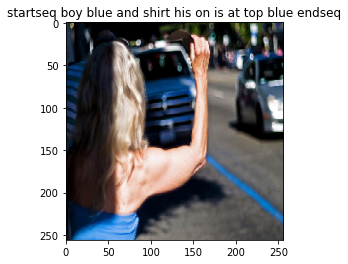

In [31]:
test_img=list(test_cap_tok.keys())[0]
test_photo = load_preprocess_img(image_pth_rt + test_img)
cap=caption_greedy(actor_model,test_photo,tokenizer,word_index)
plt.imshow(test_photo)
plt.title(cap)
tokenization=tokenizer.texts_to_sequences([cap])
seq_cap=tf.keras.preprocessing.sequence.pad_sequences(tokenization, maxlen=25,
                                                                            padding='post')
input_ds=[tf.expand_dims(test_photo,axis=0),seq_cap]
reward=Rewards(reward_model,input_ds)
print(reward)

In [32]:
epoch=0
num_epoch=100
step=0
stp_loss=[]
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)
for key, desc_list in description_map1.items(): 
    step+=1  
    test_photo = load_preprocess_img(image_pth_rt + key)
    predicted_cap=caption_greedy(actor_model,test_photo,tokenizer,word_index)
    tokenization=tokenizer.texts_to_sequences([predicted_cap])
    seq_cap=tf.keras.preprocessing.sequence.pad_sequences(tokenization, maxlen=25,
                                                                            padding='post')
    
    input_ds=[tf.expand_dims(test_photo,axis=0),seq_cap]
    #print(input_ds)
    with tf.GradientTape() as tape:
      value = value_model(input_ds, training=True)  
      reward=Rewards(reward_model,input_ds)
      losses=tf.keras.losses.mean_squared_error(value,reward) 
      stp_loss+=losses
    grads = tape.gradient(losses, value_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, value_model.trainable_weights))
    print(value[0],reward[0],losses)
    if step==num_epoch :
      step=0
      epoch+=1
      print(stp_loss)
      stp_loss=[]
      break

tf.Tensor([-0.39669678], shape=(1,), dtype=float32) tf.Tensor(0.08857204, shape=(), dtype=float32) tf.Tensor([0.23548584], shape=(1,), dtype=float32)
tf.Tensor([-0.4242891], shape=(1,), dtype=float32) tf.Tensor(0.16039257, shape=(), dtype=float32) tf.Tensor([0.34185266], shape=(1,), dtype=float32)
tf.Tensor([0.336529], shape=(1,), dtype=float32) tf.Tensor(0.21774942, shape=(), dtype=float32) tf.Tensor([0.01410859], shape=(1,), dtype=float32)


KeyboardInterrupt: ignored

In [33]:
optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001)
history={}
history['loss']=list()
history['val_loss']=list()
metrics_names = ['loss'] 
epochs = 1
num_epoch=400
for i in range(epochs):
    n=0
    epoch=0
    for step, x_batch_train in enumerate(trn_dataset):
        if epoch==num_epoch:
          break
        progbar = tf.keras.utils.Progbar(10,stateful_metrics=['loss'])
        with tf.GradientTape() as tape:
            input_image=x_batch_train[0]
            input_seq=x_batch_train[1][:,:np.random.randint(15)]
            input_padseq=tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=25,
                                                                            padding='post')
            input_batch=[input_image,input_padseq]
            value = value_model(x_batch_train, training=True)  
            reward=Rewards(reward_model,x_batch_train)
            loss_value = tf.keras.losses.mean_squared_error(value,reward)

        grads = tape.gradient(loss_value, value_model.trainable_weights)

        optimizer.apply_gradients(zip(grads, value_model.trainable_weights))
        progbar.update(n, values = [("loss", loss_value)])
        n+=1
        if step % 10 == 0:
            epoch+=1
            val_ds=next(iter(val_dataset))
            val_value = value_model(val_ds)
            
            val_reward=Rewards(reward_model,val_ds)
           
            val_loss_value=tf.keras.losses.mean_squared_error(val_value,val_reward)
            progbar.add(1,values = [("val_loss", val_loss_value)])
            n=0
            print(val_value.numpy()[0][0],val_reward.numpy()[0])
            print("\nepoch %d" % (epoch,))
            history['loss'].append(loss_value)
            history['val_loss'].append(val_loss_value)

 1/10 [==>...........................] - ETA: 7s - loss: 0.0845 - val_loss: 0.04610.28576037 0.0014509422

epoch 1
10/10 [==============================] - 1s 68ms/step - loss: 0.0724 - val_loss: 0.3507
-0.5769697 0.15018451

epoch 2
10/10 [==============================] - 1s 65ms/step - loss: 0.0825 - val_loss: 0.0782
-0.47338292 0.031705834

epoch 3
10/10 [==============================] - 1s 67ms/step - loss: 0.0417 - val_loss: 0.0775
-0.035808515 -0.01792803

epoch 4
10/10 [==============================] - 1s 66ms/step - loss: 0.0877 - val_loss: 0.0723
0.30599782 -0.061404377

epoch 5
10/10 [==============================] - 1s 66ms/step - loss: 0.2642 - val_loss: 0.0506
-0.16346757 -0.050890274

epoch 6
10/10 [==============================] - 1s 66ms/step - loss: 0.0641 - val_loss: 0.0143
0.039866824 -0.0576539

epoch 7
10/10 [==============================] - 1s 66ms/step - loss: 0.0822 - val_loss: 0.1537
-0.225905 0.04857167

epoch 8
10/10 [==============================] - 1

In [34]:
f = open("/content/history_value_model_SGD_incp_lstm.pkl", "wb")
pickle.dump(history, f)
f.close() 

In [36]:
#value_model.save_weights('/content/drive/MyDrive/Kaggle/value_net_weights_all.h5')

In [1]:
import matplotlib.pyplot as plt

In [2]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

NameError: ignored